In [3]:
import torch

from datasets import load_dataset

from unsloth import FastVisionModel
from unsloth import is_bf16_supported
from trl import SFTTrainer, SFTConfig
from unsloth.trainer import UnslothVisionDataCollator

In [4]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

==((====))==  Unsloth 2025.3.18: Fast Mllama patching. Transformers: 4.50.1.
   \\   /|    NVIDIA H100 NVL. Num GPUs = 1. Max memory: 93.003 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, 
    finetune_language_layers   = True, 
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 16,           
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3443,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [6]:
dataset = load_dataset("philschmid/amazon-product-descriptions-vlm", split = "train[0:500]")

README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/47.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1345 [00:00<?, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['image', 'Uniq Id', 'Product Name', 'Category', 'Selling Price', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Variants', 'Product Url', 'Is Amazon Seller', 'description'],
    num_rows: 500
})

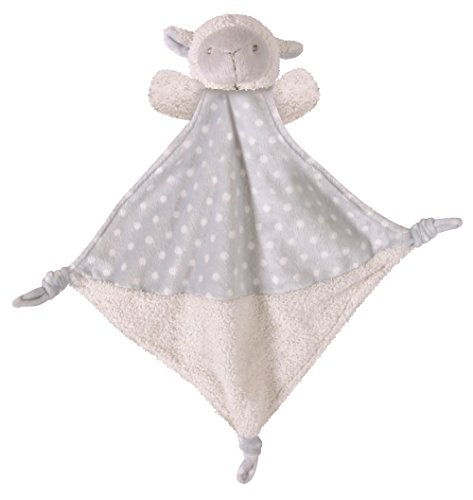

In [8]:
dataset[50]['image']

In [9]:
instruction = """
You are an expert Amazon worker who is good at writing product descriptions. 
Write the product description accurately by looking at the image.
"""


def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": sample["description"]}],
        },
    ]
    return {"messages": conversation}


pass


converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [10]:
converted_dataset[45]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': '\nYou are an expert Amazon worker who is good at writing product descriptions. \nWrite the product description accurately by looking at the image.\n'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x302>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Authentic Dale Earnhardt Jr. 1:24 scale diecast car. Nationwide Raw Finish.  Collectible model car for racing fans.  Perfect gift for NASCAR enthusiasts.'}]}]}

In [11]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[45]["image"]

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ],
    }
]
input_text = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1
)

The<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>
You are an expert Amazon worker who is good at writing product descriptions. 
Write the product description accurately by looking at the image.
<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The image shows a race car, but it does not depict the product of a business like Amazon. Instead, it appears to be a NASCAR vehicle sponsored by Nationwide Insurance and Dale Earnhardt Jr. This makes it unlikely that it would be a product sold on the Amazon platform.

The car in the image is a Chevrolet SS race car, as indicated by the logo on the front grille and the distinctive design of the car. It has a silver and blue body with white accents and the number 88 prominently displayed on the hood and sides. The car also features various sponsor decals and logos, including those of Nationwide Insurance, Goodyear tires,


In [12]:
FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset=converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=5,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="/Utilisateurs/umushtaq/multimodal_er/EmoComics35/model_outputs",
        report_to="none",  # For Weights and Biases
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,3.364900
10,2.157000
15,1.298300
20,1.114200
25,1.011600
30,1.052800


/Utilisateurs/umushtaq/.conda/envs/multimodaler/lib/python3.11/site-packages/peft/utils/other.py:1094: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /unsloth/llama-3.2-11b-vision-instruct-bnb-4bit/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7fe3eb444690>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 78f2c9d6-ef0b-4202-8788-c020455d3a79)') - silently ignoring the lookup for the file config.json in unsloth/llama-3.2-11b-vision-instruct-bnb-4bit.
  warnings.warn(
/Utilisateurs/umushtaq/.conda/envs/multimodaler/lib/python3.11/site-packages/peft/utils/save_and_load.py:227: UserWarning: Could not find a config file in unsloth/llama-3.2-11b-vision-instruct-bnb-4bit - will assume that the vocabulary was not modified.
  warnings.warn(


In [14]:
trainer_stats

TrainOutput(global_step=30, training_loss=1.6664584477742512, metrics={'train_runtime': 310.5282, 'train_samples_per_second': 0.773, 'train_steps_per_second': 0.097, 'total_flos': 1492377653265804.0, 'train_loss': 1.6664584477742512})

In [ ]:
# ok works